## NLP Sentiment Analysis - Movie Reviews Binary Classifier

The following code was developed as a project for the 'AI Fundamentals' class at Keio University. Pytorh is used as the main library.
The main objective of the project was to build a FFD-NN binary classifier for a dataset of IBDM movie reviews, which are classified as positive (1) or negative (0). The input to the FFD architecture are sentences. Each word of the sentenced is mapped to a 10-dimensional word embedding (learned from the data), subsequently all the word embeddings in the senteces are averaged out. This method totally disregards the order of the words in a sentence and thus will not be able to spot subtle use of language such as irony or sarcasm. Nevertheless, it achieved good results despite its simplicity.
The final step of the project was to analyse the derived word embeddings by means of the euclidean norm.

In [7]:
# importing the libraries I need
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(14, 8))
plt.rc('grid', color='gray', alpha = 0.3, linestyle='solid')
import os
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import nltk  # natural language toolkit
from nltk.tokenize import word_tokenize
# from nltk.corpus import stopwords      I actually dodn't use this

In [8]:
root_dir = os.getcwd()

# Defining a file reader to read train, dev and test data
def read_file(file_name):
    '''
    Takes as input either the train, dev or test file names and outputs a list of lists
    containg datapoints consisting of a sentence (string) and a target (an integer)
    '''
    with open(file_name,'r') as text_file:
        l = []
        for line in text_file:
            l.append(line.rstrip().split('\t'))
            
        # Transforming target variables from stings to integers
        l = [[sentence, int(target)] for sentence, target in l]
        
        return(l)

# loading train, dev and test data
train_list = read_file('senti_binary.train')
dev_list = read_file('senti_binary.dev')
test_list = read_file('senti_binary.test')

In [9]:
# Check that everything worked as expected

print(train_list[1])

['contains no wit , only labored gags', 0]


In [10]:
# To deal with apostrophes after tokenization has taken place

apostrophe_dict = {
"n't" : "not",
"'d"  : "would",
"'ll" : "will",
"'m"  : "am",
"'s"  : "is",
"'re" : "are",
"'ve" : "have",
"wo"  : "will",  # won't -> [wo, n't] -> [will, not]
"sha" : "shall"  # shan't -> [sha, n't] -> [shall, not]
}

In [11]:
# Defining a useful function to preprocess the text of the sentences
def text_preprocess(sentence):
    
    #1.st step: lowercase
    sentence_lower = sentence.lower()
    
    #2.nd sep: replace '-' with ' ' so we won't lose words in step 5
    sentence_replace = sentence_lower.replace('-',' ')
    
    # 3.rd step: tokenization
    sentence_token = word_tokenize(sentence_replace)
    
    # 4.th step: apostrophe handling
    setence_apostrophe = [apostrophe_dict[word] if word in apostrophe_dict else word for word in sentence_token]
    
#########    
    # I will no remove stop words because I tried and keeping them improves the accuracy of the models
    
    # 5.th step: removing stop words
#     sentence_stop = [word for word in setence_apostrophe if word not in stopwords.words('english')]
#########    
    
    # 6.th step: removing non alphabetic characters
    sentence_alpha = [word for word in setence_apostrophe if word.isalpha()]
    
    return(sentence_alpha)

In [20]:
# Check
print(text_preprocess(train_list[1][0]))

['contains', 'no', 'wit', 'only', 'labored', 'gags']


In [12]:
# Let's now build our dictionary of words.

# First, preprocess all the sentences in the train set
train_sentences_list = [text_preprocess(datapoint[0]) for datapoint in train_list]

# Getting the length of the sentences (it will be useful later)
train_sentences_lengths = np.array([len(sentence) for sentence in train_sentences_list])

# Now, flatten the list, remove the duplicates and sort the list
train_words_list = [word  for sentence in train_sentences_list for word in sentence]

train_unique_words_list = []
for word in train_words_list:
    if not (word in train_unique_words_list):
        train_unique_words_list.append(word)

train_unique_words_list.sort()

# Finally, let's create the dictionary which associates
word_to_idx = {word: (i+1) for i, word in enumerate(train_unique_words_list)}

# Let's add to the thictionary, to index 0, a word called __unknown__ for which we will map all the words we don't know
word_to_idx['__unknown__'] = 0

# Let's define a dictionary to retrieve the words from the indexes
idx_to_word = {word_to_idx[word]: word for word in word_to_idx} 

# Print the length of the dictionary:
print('The length of our dictionary is: ', len(word_to_idx))

The length of our dictionary is:  13623


In [19]:
# Check
print(word_to_idx['contains'])

2456

Max length of a sentence is:  48


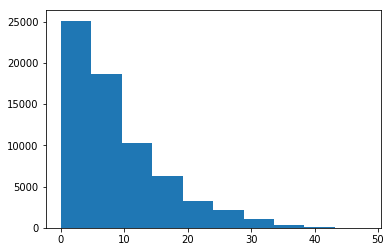

In [7]:
# Let's visualize the distribution of the lengths of the sentences

plt.hist(train_sentences_lengths);

print('Max length of a sentence is: ', np.max(train_sentences_lengths))

Since our architecture will have a fixed-lenght input, all of our sentences must be of fixed length. Since the maximum length of a sentence is 48 words, we will set all the sentences to be 50 words. The sentences of less than 50 words will be padded with zeroes (the \__unknown__) word in order to reach length 50.

In [22]:
# Defining some useful functions

def tokenized_sentence_to_idx_tensor(tokenized_sentence):
    '''
    Takes in a list of strings and returns a 50-dimensional long tensor of indexes (of our dictionary).
    If the word are unknown or the sentence is shorter than 50, the indexes returned will be that of the
    unknown word. In our case 0.
    '''
    idx_list = []
    for i in range(50):
        
        try:
            word = tokenized_sentence[i]
            idx = word_to_idx[word]
            idx_list.append(idx)
        except:
            idx_list.append(0)
    
    return torch.LongTensor(idx_list)


def sentence_to_idx_tensor(sentence):
    '''
    Takes in a sentence in form of a string, preprocesses it and then  returns a 50-dimensional 
    long tensor of indexes (of our dictionary). If the word are unknown or the sentence is shorter than 50,
    the indexes returned will be that of the unknown word. In our case 0.
    '''
    return(tokenized_sentence_to_idx_tensor(text_preprocess(sentence)))

In [23]:
# Check
sentence_to_idx_tensor(train_list[1][0])

tensor([  2456,   8085,  13413,   8280,   6756,   4932,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0])

In [28]:
# Let's build a dataset class (Inherits from torchs' Dataset class)

class review_dataset(Dataset):
    
    def __init__(self, data, transform_features = None, transform_labels = None, n_words_in_sentence = 50):
        super().__init__()
        self.data = data
        self.n_words_in_sentence = n_words_in_sentence
        self.transform_features = transform_features
        self.transform_labels = transform_labels
        
    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, index):
        features = self.data[index][0]
        labels = self.data[index][1]
        
        if self.transform_features:
            features = self.transform_features(features)
                
        if self.transform_labels:
            labels = self.transform_labels(labels)
        
        return (features, labels)
    
    def get_tensors_dataset(self, numpy=False):
        '''
        Returns the actual dataset made up by tensors that is used internally by the NN (useful when we want to move computations on gpu)
        It il a list made up by 2 elements:
        1.st element is tensor of features
        2.nd element is the tensor of labels
        
        if numpy==True  numpy arrays instead of torch tensors are returned (Useful if we want to fit sklearn models)
        '''
        dataset_list = [self.__getitem__(i) for i in range(len(self))]
        features_list = [datapoint[0].reshape(1,-1) for datapoint in dataset_list]
        classes_list = [datapoint[1] for datapoint in dataset_list]
        
        if numpy==False:
            return (torch.cat(features_list), torch.LongTensor(classes_list))

        elif numpy==True:
            return (torch.cat(features_list).numpy(), torch.LongTensor(classes_list).numpy())
            
            
# Define instances of my reviews_dataset class (sentence_to_idx_tensor is used as a transform feature transformation)
train = review_dataset(train_list, sentence_to_idx_tensor)
dev = review_dataset(dev_list, sentence_to_idx_tensor)
test = review_dataset(test_list, sentence_to_idx_tensor)

In [29]:
# Check 
train.__getitem__(1)

(tensor([  2456,   8085,  13413,   8280,   6756,   4932,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,
              0,      0]), 0)

In [30]:
# Define a dataloader to make the training in batches

batch_size=64

train_loader = DataLoader(batch_size=batch_size,
                                  dataset=train, shuffle=True
                                    )

Let's now define a superclass for all the neural networks that we are going to build. This wrapper will contain function which are foing to be useful for all the NN that we are going to fit.

In [31]:
# Let's create a new superclass that inherits from nn.Module
# We will add the fit, generate_pictures, predict_prob and predict methods to it, to reduce lines of code

#####
# I used an exponential decaying structure of the learning rate
#####

class neural_network_sentiment(nn.Module):
    def __init__(self):
        super().__init__()
    
    def predict_prob(self, review):
        '''
        Takes in a string (theoretically a film review) and outputs a tensor representing 
        the probability distribution over 0 (nevtive review) and 1 (positive review)
        '''
        prob_distribution = F.softmax(self.forward(sentence_to_idx_tensor(review)), dim=0)
        return prob_distribution.data
    
    def predict(self, review):
        '''
        Takes in a string (theoretically a film review) and outputs a tensor representing 
        the predicted class
        '''
        prob_distribution = self.predict_prob(review)
        return int(torch.max(self.forward(sentence_to_idx_tensor(review)), 0)[1].data.numpy())
    
    def fit(self,
            train_loader,
            test_loader,
            dev_loader=None,
            initial_lr = 1,
            gamma = 0.95,
            n_epochs=30,
            score = False,
            gpu=False,
            print_results = True,
            chart=True):
        
        '''
        Takes in a dataloader for the training set, one for the test, set (if gpu==True they
        should be already on the gpu) and trains the network.
        score = True -> self.score will be defined as the accuracy on the dev set (at the last epoch).
        When score = True, you should plug in a dev_loader, or the score will be computed on the test
        print_results = True -> shows how the training is going every 10 epochs
        chart=True -> shows a chart (1x2) representing epoch vs train and test loss and accuracy
        '''
        
        if gpu==True:
            # Move the model to gpu (the datasets are supposed to be already been moved on the gpu)
            self.to(device)
        
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.SGD(self.parameters(), lr=initial_lr, momentum=0.1)
        self.scheduler = torch.optim.lr_scheduler.ExponentialLR(self.optimizer, gamma = gamma)
        
        self.train_loss = [0 for i in range(n_epochs)]
        self.test_loss = []
        self.train_accuracy = []
        self.test_accuracy = []
        
        self.n_epochs = n_epochs
        self.initial_lr = initial_lr
        self.gamma = gamma
        
        for epoch in range(n_epochs):
                
            train_correct = 0
            train_total = 0
            
            for i, (items, classes) in enumerate(train_loader):
                                    
                self.train()                             # begin training
                     
                self.optimizer.zero_grad()                # zero out gradients
                outputs = self(items)                     # forward pass
                loss = self.criterion(outputs, classes)   # get loss
                loss.backward()                           # update gradients (backprop)
                self.optimizer.step()                     # update parameters based on gradients
        
                # computes accuracy on training
                train_total += classes.size(0)            # counts the number of rows we trained
                _, predicted = torch.max(outputs.data, 1) # stores the predicted classes
                train_correct += (predicted == classes.data).sum()  # counts how many times the model got it right
        
                # adds up training losses for the batches (divided by the number of batches in order to get the mean loss of the epoch)
                self.train_loss[epoch] += loss/len(train_loader)

            self.eval()                                   # begin evaluation
    
            # save accuracy on training
            self.train_accuracy.append(100 * (train_correct.cpu().item() / train_total))
    
            # test set predictions
            outputs = self(test_loader[0])
    
            # compute and save loss on test
            loss = self.criterion(outputs, test_loader[1])
            self.test_loss.append(loss.item())
    
            # compute and save accuracy on test
            _, predicted = torch.max(outputs.data, 1)
            total = test_loader[1].size(0)
            correct = (predicted == test_loader[1]).sum()
            self.test_accuracy.append((100 * correct.cpu().item() / total))
            
            if print_results == True:
                if ((epoch+1)%1 == 0) or epoch==0:
                    print ('Epoch %d/%d, Accuracy on Training Set: %.4f, Accuracy on Test Set: %.4f'
                          %(epoch+1, n_epochs, self.train_accuracy[epoch], self.test_accuracy[epoch]))
              
            # Update learning rate
            self.scheduler.step()
            
        if chart == True:
            print('\n')
            
            fig, ax = plt.subplots(1,2)
            
            epochs = range(1,self.n_epochs +1)

            # train and test loss
            ax[0].plot(epochs, self.train_loss, label='train loss', c = 'red')
            ax[0].plot(epochs, self.test_loss, label='test loss', c = 'blue')
            ax[0].set_title("Train and Test Loss")
            ax[0].set_xlabel('Epoch')
            ax[0].set_ylabel('Loss')
            ax[0].legend()

            # train and test accuracy
            ax[1].plot(epochs, self.train_accuracy, label='train accuracy', c = 'red')
            ax[1].plot(epochs, self.test_accuracy, label='test accuracy', c = 'blue')
            ax[1].set_title("Train and Test Accuracy")
            ax[0].set_xlabel('Epoch')
            ax[0].set_ylabel('Accuracy')
            ax[1].legend(); 
            
            self.chart = fig
        
        if score == True:
            if dev_loader:
                outputs = self(dev_loader[0])
                _, predicted = torch.max(outputs.data, 1)
                total = dev_loader[1].size(0)
                correct = (predicted == dev_loader[1]).sum()
                self.score = 100 * (correct.cpu().item() / total)
            else:
                self.score = self.test_accuracy[-1]
                
        # Move again the neural network on the cpu (to make the other methods work)
        if gpu == True:
            torch.cuda.empty_cache() 
            self.cpu()
        
    def generate_training_pictures(self):
                
        '''
        This method can only be used after the fit method has been called. It generates two pictures
        that show the dynamics of the loss and accuracy for train and test set during training
        model object attributes
        '''
        
        plt.rc('figure', figsize=(14, 8))
        plt.rc('grid', color='gray', alpha = 0.3, linestyle='solid')
            
        fig1, ax1 = plt.subplots()
            
        epochs = range(1,self.n_epochs +1)
            
        ax1.plot(epochs, self.train_loss, label='train loss', c = 'red')
        ax1.plot(epochs, self.test_loss, label='test loss', c = 'blue')
        ax1.set_title("Train and Test Loss")
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
            
        fig2, ax2 = plt.subplots()
            
        ax2.plot(epochs, self.train_accuracy, label='train accuracy', c = 'red')
        ax2.plot(epochs, self.test_accuracy, label='test accuracy', c = 'blue')
        ax2.set_title("Train and Test Accuracy")
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend(); 
            
        self.fig1 = fig1
        self.fig2 = fig2

In [32]:
# Let's move the datasets to the GPU in case we want to train the model there

# Initializes the device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Move the training set dataloader to the gpu
train_loader_gpu = [(features.to(device), labels.to(device)) for (features,labels) in train_loader]

# Creating tensors for the dev set
dev_loader = dev.get_tensors_dataset()
dev_loader_gpu = [element.to(device) for element in dev_loader]

# Creating tensors for the test set
test_loader = test.get_tensors_dataset()
test_loader_gpu = [element.to(device) for element in test.get_tensors_dataset()]

Let's start with a fairly simple perceptron architecture. The final layer of this architecture is going to be a simple linear map with 2 output nodes, which will contain the score assigned to each class. The most intresting part of the architecture is going to be the first input layer and how it is 'created'. As we saw earlier, the input is going to be a 50-dimensional vector of integers, which represent the position of the word in our dictionary. In order to transform this 50-dimensional vector into an average of word embedding (we wil use a 10-dimensial one) we need to follow 2 steps. The first step is to define the embeddings matrix, instead of relying on pre-computed embedding matrices we are going to train our own. The embedding smatrix has dimension length_dictionary x n, where n is the dimension of a single word embedding. The $i^{th}$ row of the embeddings matrix is the word embedding corresponding to the $i^{th}$ word of our dictionary. So far so good. The second step is to define some matrix calculations involving our inputs that actually compute the average of the word embeddings contained in a sentence. 
The first operation is to transform our 50-dimensional vector into a list of 50 length_dictionary-dimensional vectors such that an integer m is transformed into the mth canonical basis vector of a length_dictionary-dimensional space. When we compute a dot product between the embeddings matrix and each of this newly crated 50 vectors, we will obtain 50 10-dimensional embedding vectors, which will be then averaged together. Pytorch takes care of defining and training the embeddings matrix as well al all the matrix calculations involving the embeddings matrix. The final 10-dimensional vector (average of the 50 dimensional vectors) will then be the input for the first and last linear layer.

In [33]:
# Now let's try to build a very simple model that learns the "sentiment-based word embeddings", and then output a sentiment for the sentence 
# Averaging these embeddings and then input them in a simple perceptron classifier

class perceptron(neural_network_sentiment):
    
    def __init__(self, dictionary_length, n_embeddings, n_classes):
        super().__init__()
        self.dictionary_length = dictionary_length
        self.n_embeddings = n_embeddings
        self.n_classes = n_classes
        
        # padding_idx=0 makes sure the embedding for the __unknown__ word is 0
        self.embeddings = nn.Embedding(dictionary_length, self.n_embeddings, padding_idx=0, sparse=True) 
        
        # Now that we have our embeddings we input them in a simple linar layer
        self.fc1 = nn.Linear(self.n_embeddings, self.n_classes)
        
        
    def forward(self, x):
        embeds = self.embeddings(x)
        
        # Now we average the embeddings we get out in order to get a single embedding for the entire sentence
        # First check if you have a single example or a batch and then compute the means
        
        if len(embeds.shape) == 2:
            mean_embeds = torch.mean(embeds,0)
            
        elif len(embeds.shape) == 3:
            mean_embeds = []
            for embed in embeds:
                mean_embeds.append(torch.mean(embed,0).reshape(1,self.n_embeddings))
            mean_embeds = torch.cat(mean_embeds, 0)
            
        #Then we put the resulting embedding into a linear layer
        out = self.fc1(mean_embeds)
        
        return(out)

In [34]:
# Instantiate the perceptron
my_embedings_perceptron = perceptron(len(word_to_idx), 10, 2)

Epoch 1/30, Accuracy on Training Set: 55.5613, Accuracy on Test Set: 49.9176
Epoch 2/30, Accuracy on Training Set: 57.0610, Accuracy on Test Set: 52.7183
Epoch 3/30, Accuracy on Training Set: 59.5540, Accuracy on Test Set: 56.6722
Epoch 4/30, Accuracy on Training Set: 62.0989, Accuracy on Test Set: 60.7908
Epoch 5/30, Accuracy on Training Set: 64.5266, Accuracy on Test Set: 63.7562
Epoch 6/30, Accuracy on Training Set: 66.6023, Accuracy on Test Set: 66.3921
Epoch 7/30, Accuracy on Training Set: 68.4554, Accuracy on Test Set: 68.5338
Epoch 8/30, Accuracy on Training Set: 70.1510, Accuracy on Test Set: 69.5222
Epoch 9/30, Accuracy on Training Set: 71.5794, Accuracy on Test Set: 70.7853
Epoch 10/30, Accuracy on Training Set: 72.8994, Accuracy on Test Set: 71.3344
Epoch 11/30, Accuracy on Training Set: 74.0352, Accuracy on Test Set: 72.5426
Epoch 12/30, Accuracy on Training Set: 75.1162, Accuracy on Test Set: 73.3114
Epoch 13/30, Accuracy on Training Set: 76.0427, Accuracy on Test Set: 74.

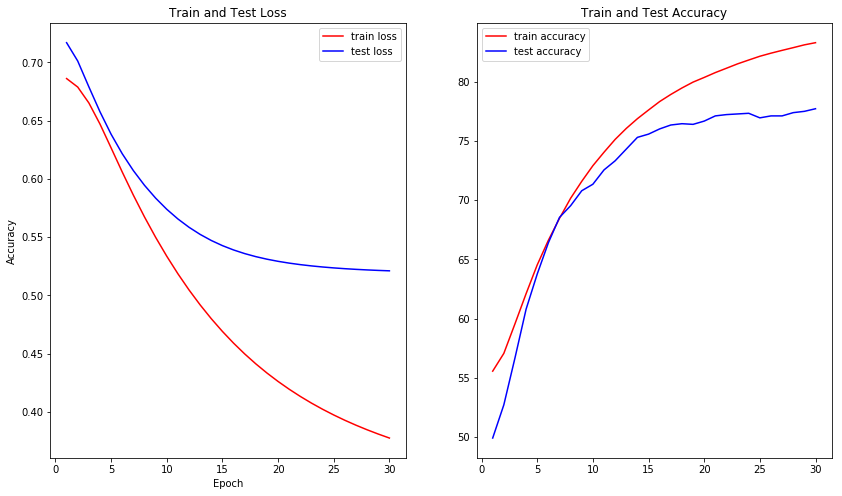

In [35]:
my_embedings_perceptron.fit(train_loader_gpu, test_loader_gpu, gpu=True)

The very simple perceptron architecture achieved an anccuracy of 77.7% on the test set. Let's now try to feed it some examples to see where it stands.

In [43]:
my_embedings_perceptron.predict('I really liked the main actor and the storyline')

1

In [41]:
my_embedings_perceptron.predict('I am quite unsure about whether I like this movie...')

0

In [42]:
my_embedings_perceptron.predict('Looking forward to the sequel...')

1

In [45]:
my_embedings_perceptron.predict('After watching this movie, I want to die')

0

As a next step, we are going to try with a more complex architecture. For instance, after the embeddings layer and before the last layer, we will add a 30-dimensional hidden layer.

In [50]:
# Now let's try with a more complex architecture

class deep_nn(neural_network_sentiment):
    
    def __init__(self, dictionary_length, n_embeddings, n_hidden, n_classes):
        super().__init__()
        self.dictionary_length = dictionary_length
        self.n_embeddings = n_embeddings
        self.n_classes = n_classes
        self.n_hidden = n_hidden
        
        self.act = nn.ReLU()
        self.embeddings = nn.Embedding(dictionary_length, self.n_embeddings, padding_idx=0, sparse=True) 
        self.fc1 = nn.Linear(n_embeddings, n_hidden)
        self.fc2 = nn.Linear(n_hidden, n_classes)

        
    def forward(self, x):
        embeds = self.embeddings(x)
        
        if len(embeds.shape) == 2:
            mean_embeds = torch.mean(embeds, 0)
            
        elif len(embeds.shape) == 3:
            mean_embeds = []
            for embed in embeds:
                mean_embeds.append(torch.mean(embed,0).reshape(1,self.n_embeddings))
            mean_embeds = torch.cat(mean_embeds, 0)
        
        
        out = self.fc1(mean_embeds)
        out = self.act(out)
        out = self.fc2(out)
        return(out)

In [51]:
# Instantiate the nework
my_deep_nn_0 = deep_nn_0(len(word_to_idx), 10, 30, 2)

Epoch 1/30, Accuracy on Training Set: 55.4663, Accuracy on Test Set: 52.1142
Epoch 2/30, Accuracy on Training Set: 57.9207, Accuracy on Test Set: 55.9033
Epoch 3/30, Accuracy on Training Set: 60.4092, Accuracy on Test Set: 58.5942
Epoch 4/30, Accuracy on Training Set: 62.7760, Accuracy on Test Set: 61.7243
Epoch 5/30, Accuracy on Training Set: 65.0997, Accuracy on Test Set: 64.3053
Epoch 6/30, Accuracy on Training Set: 67.2007, Accuracy on Test Set: 65.8979
Epoch 7/30, Accuracy on Training Set: 69.2082, Accuracy on Test Set: 67.9297
Epoch 8/30, Accuracy on Training Set: 71.1057, Accuracy on Test Set: 69.5772
Epoch 9/30, Accuracy on Training Set: 72.6574, Accuracy on Test Set: 70.4009
Epoch 10/30, Accuracy on Training Set: 74.2075, Accuracy on Test Set: 70.8402
Epoch 11/30, Accuracy on Training Set: 75.4458, Accuracy on Test Set: 71.4992
Epoch 12/30, Accuracy on Training Set: 76.6440, Accuracy on Test Set: 72.2131
Epoch 13/30, Accuracy on Training Set: 77.6493, Accuracy on Test Set: 72.

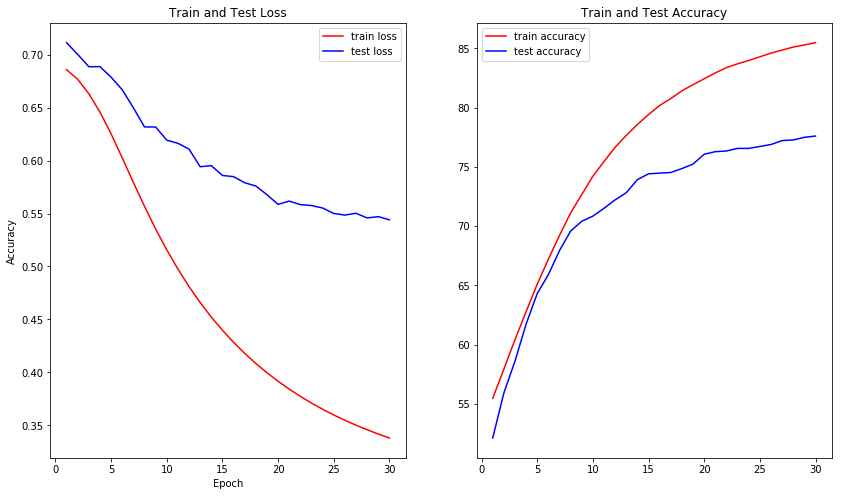

In [52]:
my_deep_nn_0.fit(train_loader_gpu, test_loader_gpu, gpu=True)

The more complex architecture does not seem to have improved the accuracy measure on the test set. We will choose this model as the final model regardless of this.

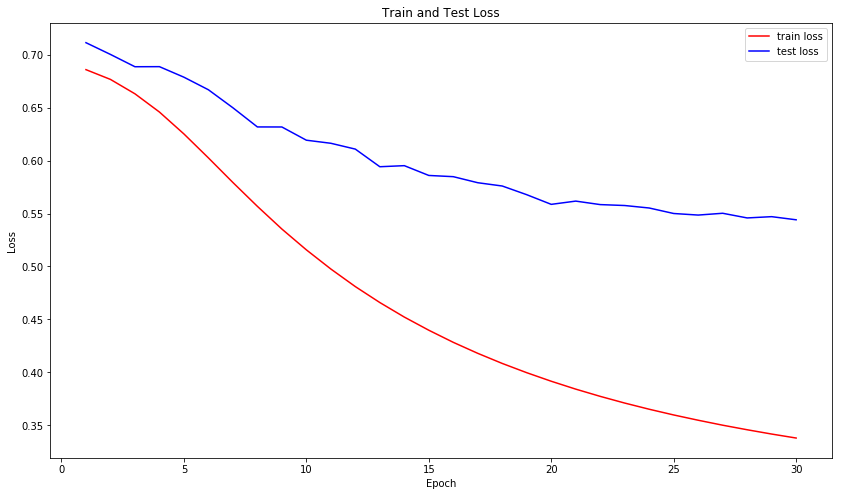

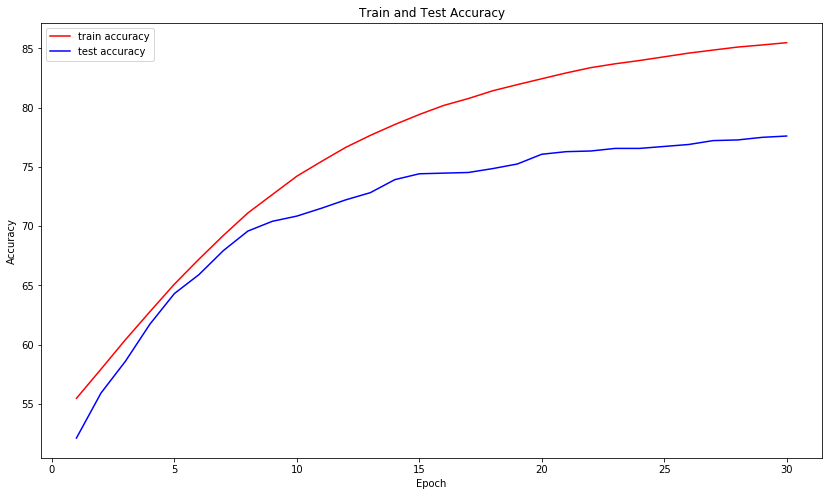

In [53]:
# Let's pick model my_deep_nn_0_0 as it showed superior performance
final_model = my_deep_nn_0

# Generate the pictures
my_deep_nn_0.generate_training_pictures()

In [54]:
final_model.predict('I really liked the main actor and the storyline')

1

In [55]:
final_model.predict('I am quite unsure about whether I like this movie...')

0

In [56]:
final_model.predict('Looking forward to the sequel...')

0

In [57]:
final_model.predict('After watching this movie, I want to die')

0

In [58]:
# Create a dictionary with our learned embeddings. Extracting them from the embeddings layer.

my_embeddings = {word: final_model.embeddings(torch.LongTensor([word_to_idx[word]])) for word in word_to_idx}

In [59]:
# Check
my_embeddings['amazing']

tensor([[ 0.7528,  0.5303,  1.2054,  1.5776, -0.2745, -0.6218,  1.1140,
         -0.9991,  0.1550, -0.4906]])

As a final step for the project, let's compare the embeddings by means of the euclidean norm. Because of how the architecture is constructed, we would expect that words that carry little meaning in realation to the sentiment classification task would have a small euclidean norm, as they would carry less weight when computing the mean. On the other hand, words which carry greater meaning in relation to the task are expected to carry also greater euclidian norms.

In [60]:
# Compute the euclidian norm and sort the words by their norms

norms_array = np.array([[idx, torch.norm(my_embeddings[idx_to_word[idx]]).data.numpy()] for idx in idx_to_word])
norms_dataframe = pd.DataFrame(norms_array, columns=['Index', 'Euclidian Norm'])
norms_dataframe['Word'] = list(map(lambda x: idx_to_word[x], norms_dataframe.Index))
norms_dataframe.head()

,Index,Euclidian Norm,Word
0,1.0,3.030581,a
1,2.0,3.655054,aaa
2,3.0,2.927698,aaliyah
3,4.0,3.852015,aan
4,5.0,2.750056,abandon


In [61]:
# Let's sort the dataframe by the squared norm
norms_dataframe_sorted = norms_dataframe.sort_values(['Euclidian Norm'])
norms_dataframe_sorted.head(10)

,Index,Euclidian Norm,Word
13622,0.0,0.000000,__unknown__
8944,8945.0,0.948282,plumbing
1163,1164.0,0.974565,black
6076,6077.0,0.988438,indescribably
3776,3777.0,1.021570,elements
3729,3730.0,1.052856,effecting
9525,9526.0,1.082948,ramblings
7282,7283.0,1.110870,makes
5047,5048.0,1.114822,gets
7149,7150.0,1.119080,louis


In [62]:
norms_dataframe_sorted.tail(10)

,Index,Euclidian Norm,Word
2565,2566.0,5.721457,corpus
2675,2676.0,5.746893,credulity
32,33.0,5.849086,absorbed
8896,8897.0,5.944662,play
1372,1373.0,5.949636,boyd
5182,5183.0,5.980849,gore
8124,8125.0,5.998602,not
7275,7276.0,6.326975,majidi
5977,5978.0,6.337446,imperfect
13493,13494.0,6.760353,worst


The sorted words seem to confirm our assumptions about the meaning of the words, with a few exceptions which are probably peculiar to this dataset.

In [63]:
# Saving the files needed for submission

# Creating Directory
if not os.path.exists(root_dir + '/to_submit'):
    os.makedirs(root_dir + '/to_submit')

# Changing working directory
os.chdir(root_dir + '/to_submit')

# Saving the model as a dict
torch.save(final_model.state_dict(), "./part2_state.chkpt")

# Saving Accuracy on train and test set in a new text file
with open('project1_part2_results.txt','w+') as file:
    file.write(str(final_model.train_accuracy[-1]))
    file.write('\n')
    file.write(str(final_model.test_accuracy[-1]))
    file.close()

# Saving plots
final_model.fig1.savefig('project1_part2_plots_loss.png')
final_model.fig2.savefig('project1_part2_plots_accuracy.png')